In [89]:
import numpy as np
import csv

# Function to read the header
def read_header(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
    return header

# Read headers
x_test_header = read_header('dataset/x_test.csv')
y_train_header = read_header('dataset/y_train.csv')
x_train_header = read_header('dataset/x_train.csv')

# Load csvs x_test, y_test and x_train, skipping the header row
x_test = np.genfromtxt('dataset/x_test.csv', delimiter=',', skip_header=1)
y_train = np.genfromtxt('dataset/y_train.csv', delimiter=',', skip_header=1)
x_train = np.genfromtxt('dataset/x_train.csv', delimiter=',', skip_header=1)
x_train_cleaned = x_train.copy()
x_test_cleaned = x_test.copy()

# Convert column names to indices and combine with automatically identified columns
columns_to_drop_by_index = []
for i in range(x_train_cleaned.shape[1]): 
    unique_values = np.unique(x_train_cleaned[:, i][~np.isnan(x_train_cleaned[:, i])]) 
    if len(unique_values) == 1: 
        columns_to_drop_by_index.append(i)  # Append the index

# Combine indices of manually specified columns and automatically detected ones
columns_to_drop_indices = columns_to_drop_by_index #+ [i for i, col in enumerate(x_train_header) if col in columns_to_drop_by_name]

# Drop these columns in both x_train and x_test
x_train_cleaned = np.delete(x_train_cleaned, columns_to_drop_indices, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, columns_to_drop_indices, axis=1)

# Drop the same columns from the headers
x_train_header_cleaned = [col for i, col in enumerate(x_train_header) if i not in columns_to_drop_indices]
x_test_header_cleaned = [col for i, col in enumerate(x_test_header) if i not in columns_to_drop_indices]



print(x_train.shape)
print(x_train_cleaned.shape)


(328135, 322)
(328135, 316)


create dummy variable for each state


In [90]:

# Extract the _STATE column from x_train_cleaned and x_test_cleaned
state_column_index = x_train_header_cleaned.index("_STATE")  # Get the index of the _STATE column
state_train = x_train_cleaned[:, state_column_index]
state_test = x_test_cleaned[:, state_column_index]

# Identify unique states
unique_states = np.unique(state_train)

# Function to create dummy variables
def create_dummy_variables(state_column, unique_states):
    dummy_matrix = np.zeros((state_column.shape[0], unique_states.shape[0]))  # Initialize the matrix
    
    for i, state in enumerate(unique_states):
        dummy_matrix[:, i] = (state_column == state).astype(int)  # Set 1 where the state matches, 0 otherwise
    
    return dummy_matrix

# Create dummy variables for both train and test
dummy_train = create_dummy_variables(state_train, unique_states)
dummy_test = create_dummy_variables(state_test, unique_states)

# Remove the original _STATE column from x_train_cleaned and x_test_cleaned
x_train_cleaned = np.delete(x_train_cleaned, state_column_index, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, state_column_index, axis=1)

# Append the dummy variables to the original dataset
x_train_cleaned = np.hstack((x_train_cleaned, dummy_train))
x_test_cleaned = np.hstack((x_test_cleaned, dummy_test))

# Add dummy variable column names to the headers
dummy_headers = [f"STATE_{int(state)}" for state in unique_states]  # Create dummy headers like "STATE_1", "STATE_2", etc.
x_train_header_cleaned = [col for col in x_train_header_cleaned if col != "_STATE"] + dummy_headers
x_test_header_cleaned = [col for col in x_test_header_cleaned if col != "_STATE"] + dummy_headers



print(x_train_cleaned.shape)


(328135, 368)


remove columns that have move more that 60% nans


In [91]:
#remove columns with more than 60% missing values from x_train_cleaned and x_test_cleaned
missing_values_threshold = 0.6
columns_to_drop = []
for i in range(x_train_cleaned.shape[1]):
    missing_values = np.isnan(x_train_cleaned[:, i]).sum() / x_train_cleaned.shape[0]
    if missing_values > missing_values_threshold:
        columns_to_drop.append(i)

x_train_cleaned = np.delete(x_train_cleaned, columns_to_drop, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, columns_to_drop, axis=1)

# Remove the same columns from the headers
x_train_header_cleaned = [col for i, col in enumerate(x_train_header_cleaned) if i not in columns_to_drop]
x_test_header_cleaned = [col for i, col in enumerate(x_test_header_cleaned) if i not in columns_to_drop]



print(x_train_cleaned.shape)


(328135, 241)


In [93]:

general_health_column_index = x_train_header_cleaned.index("GENHLTH")

# Extract the "General Health" column
gen_health_train = x_train_cleaned[:, general_health_column_index]
gen_health_test = x_test_cleaned[:, general_health_column_index]

# Function to create dummy variables for general health
def create_gen_health_dummy_variables(health_column):
    # Initialize dummy matrix (for values 1 to 5)
    dummy_matrix = np.zeros((health_column.shape[0], 5))
    
    # Fill dummy variables based on the values in the column
    for i in range(1, 6):  # For values 1 to 5
        dummy_matrix[:, i-1] = (health_column == i).astype(int)
    
    # Values 7, 9, and nan are left as 0 in all dummies
    return dummy_matrix

# Create dummy variables for both train and test datasets
dummy_train_gen_health = create_gen_health_dummy_variables(gen_health_train)
dummy_test_gen_health = create_gen_health_dummy_variables(gen_health_test)

# Remove the original "General Health" column from x_train_cleaned and x_test_cleaned
x_train_cleaned = np.delete(x_train_cleaned, general_health_column_index, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, general_health_column_index, axis=1)

# Append the dummy variables to the original dataset
x_train_cleaned = np.hstack((x_train_cleaned, dummy_train_gen_health))
x_test_cleaned = np.hstack((x_test_cleaned, dummy_test_gen_health))

# Update the headers
gen_health_dummy_headers = [f"GENHLTH_{i}" for i in range(1, 6)]
x_train_header_cleaned = [col for col in x_train_header_cleaned if col != "General Health"] + gen_health_dummy_headers
x_test_header_cleaned = [col for col in x_test_header_cleaned if col != "General Health"] + gen_health_dummy_headers


# Check shapes after adding dummy variables
print(x_train_cleaned.shape)
print(x_test_cleaned.shape)


(328135, 245)
(109379, 245)


In [94]:

#in columns PHYSHLTH, MENTHLTH and POORHLTH, make values 88 into 0, and values 77 and  99 into nan
physhlth_column_index = x_train_header_cleaned.index("PHYSHLTH")
menthlth_column_index = x_train_header_cleaned.index("MENTHLTH")
poorhlth_column_index = x_train_header_cleaned.index("POORHLTH")

# Replace values in PHYSHLTH and MENTHLTH and POORHLTH columns
x_train_cleaned[:, physhlth_column_index][x_train_cleaned[:, physhlth_column_index] == 88] = 0
x_train_cleaned[:, physhlth_column_index][x_train_cleaned[:, physhlth_column_index] == 77] = np.nan
x_train_cleaned[:, physhlth_column_index][x_train_cleaned[:, physhlth_column_index] == 99] = np.nan

x_train_cleaned[:, menthlth_column_index][x_train_cleaned[:, menthlth_column_index] == 88] = 0
x_train_cleaned[:, menthlth_column_index][x_train_cleaned[:, menthlth_column_index] == 77] = np.nan
x_train_cleaned[:, menthlth_column_index][x_train_cleaned[:, menthlth_column_index] == 99] = np.nan

x_train_cleaned[:, poorhlth_column_index][x_train_cleaned[:, poorhlth_column_index] == 88] = 0
x_train_cleaned[:, poorhlth_column_index][x_train_cleaned[:, poorhlth_column_index] == 77] = np.nan
x_train_cleaned[:, poorhlth_column_index][x_train_cleaned[:, poorhlth_column_index] == 99] = np.nan

# Replace values in PHYSHLTH and MENTHLTH columns in test dataset
x_test_cleaned[:, physhlth_column_index][x_test_cleaned[:, physhlth_column_index] == 88] = 0
x_test_cleaned[:, physhlth_column_index][x_test_cleaned[:, physhlth_column_index] == 77] = np.nan
x_test_cleaned[:, physhlth_column_index][x_test_cleaned[:, physhlth_column_index] == 99] = np.nan

x_test_cleaned[:, menthlth_column_index][x_test_cleaned[:, menthlth_column_index] == 88] = 0
x_test_cleaned[:, menthlth_column_index][x_test_cleaned[:, menthlth_column_index] == 77] = np.nan
x_test_cleaned[:, menthlth_column_index][x_test_cleaned[:, menthlth_column_index] == 99] = np.nan

x_test_cleaned[:, poorhlth_column_index][x_test_cleaned[:, poorhlth_column_index] == 88] = 0
x_test_cleaned[:, poorhlth_column_index][x_test_cleaned[:, poorhlth_column_index] == 77] = np.nan
x_test_cleaned[:, poorhlth_column_index][x_test_cleaned[:, poorhlth_column_index] == 99] = np.nan


All catergorical variables will be treated with the following sell. Categorical columns are the ones with <= 8 distinct values. The values 7 and 9 always mean Don’t know/Not Sure and Refused, respectively. No need to create a dummy variable for them

In [95]:

def identify_categorical_columns(train_data, test_data, train_headers):
    categorical_columns = []
    num_columns = train_data.shape[1]
    
    for idx in range(num_columns):
        # Combine data from train and test sets for the column
        train_column = train_data[:, idx]
        test_column = test_data[:, idx]
        combined_column = np.concatenate((train_column, test_column))
        
        # Exclude np.nan values
        unique_values = np.unique(combined_column[~np.isnan(combined_column)])
        
        # Check if all values are integers between 1 and 9
        if np.all((unique_values >= 1) & (unique_values <= 9)) and np.all(unique_values.astype(int) == unique_values):
            # Check if the number of unique values is less than or equal to 8
            if unique_values.size <= 8:
                categorical_columns.append(idx)
    return categorical_columns

def create_dummy_variables_for_column(data, headers, column_idx):
    # Extract the column data
    column_data = data[:, column_idx]
    column_name = headers[column_idx]
    
    # Replace 7, 9, and np.nan with 0
    column_data_clean = np.where(np.isin(column_data, [7, 9]) | np.isnan(column_data), 0, column_data)
    
    # Get unique values excluding 0 (which represents 7, 9, and np.nan)
    unique_values = np.unique(column_data_clean)
    unique_values = unique_values[unique_values != 0]
    
    # Remove the original column
    data = np.delete(data, column_idx, axis=1)
    del headers[column_idx]
    
    # Create dummy variables for each unique value
    for val in unique_values:
        dummy_column = np.where(column_data_clean == val, 1, 0)
        data = np.column_stack((data, dummy_column))
        headers.append(f"{column_name}_{int(val)}")
    
    return data, headers

def process_datasets(train_data, test_data, train_headers, test_headers):
    # Ensure data is of type float to handle np.nan
    train_data = train_data.astype(float)
    test_data = test_data.astype(float)
    
    # Identify categorical columns
    categorical_columns = identify_categorical_columns(train_data, test_data, train_headers)
    
    # Process columns in reverse order to avoid index shifting
    for idx in sorted(categorical_columns, reverse=True):
        # Process train data
        train_data, train_headers = create_dummy_variables_for_column(train_data, train_headers, idx)
        # Process test data
        test_data, test_headers = create_dummy_variables_for_column(test_data, test_headers, idx)
    
    return train_data, test_data, train_headers, test_headers



# Process the datasets
x_train_cleaned, x_test_cleaned, x_train_header_cleaned, x_test_header_cleaned = process_datasets(
    x_train_cleaned, x_test_cleaned, x_train_header_cleaned, x_test_header_cleaned
)



now we fill all nans with median.

In [96]:
# Function to fill NaNs with column medians from training data
def fill_nans_with_median(train_data, test_data):
    # Copy data to avoid modifying the originals
    train_data_filled = train_data.copy()
    test_data_filled = test_data.copy()
    
    # Number of columns
    num_columns = train_data.shape[1]
    
    # Iterate over each column
    for col_idx in range(num_columns):
        # Get the column data from training data
        train_col = train_data[:, col_idx]
        
        # Compute the median, ignoring NaNs
        median = np.nanmedian(train_col)
        
        # Replace NaNs in training data with the median
        nan_mask_train = np.isnan(train_col)
        train_col[nan_mask_train] = median
        train_data_filled[:, col_idx] = train_col
        
        # Replace NaNs in test data with the same median
        test_col = test_data[:, col_idx]
        nan_mask_test = np.isnan(test_col)
        test_col[nan_mask_test] = median
        test_data_filled[:, col_idx] = test_col
    
    return train_data_filled, test_data_filled

# Apply the function to your datasets
x_train_cleaned, x_test_cleaned = fill_nans_with_median(x_train_cleaned, x_test_cleaned)

In [97]:
#print column headers
print(x_train_cleaned.shape)


(328135, 402)


In [98]:
# Save cleaned data with headers
with open('dataset/x_train_cleaned.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(x_train_header_cleaned)
    writer.writerows(x_train_cleaned)

with open('dataset/x_test_cleaned.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(x_test_header_cleaned)
    writer.writerows(x_test_cleaned)

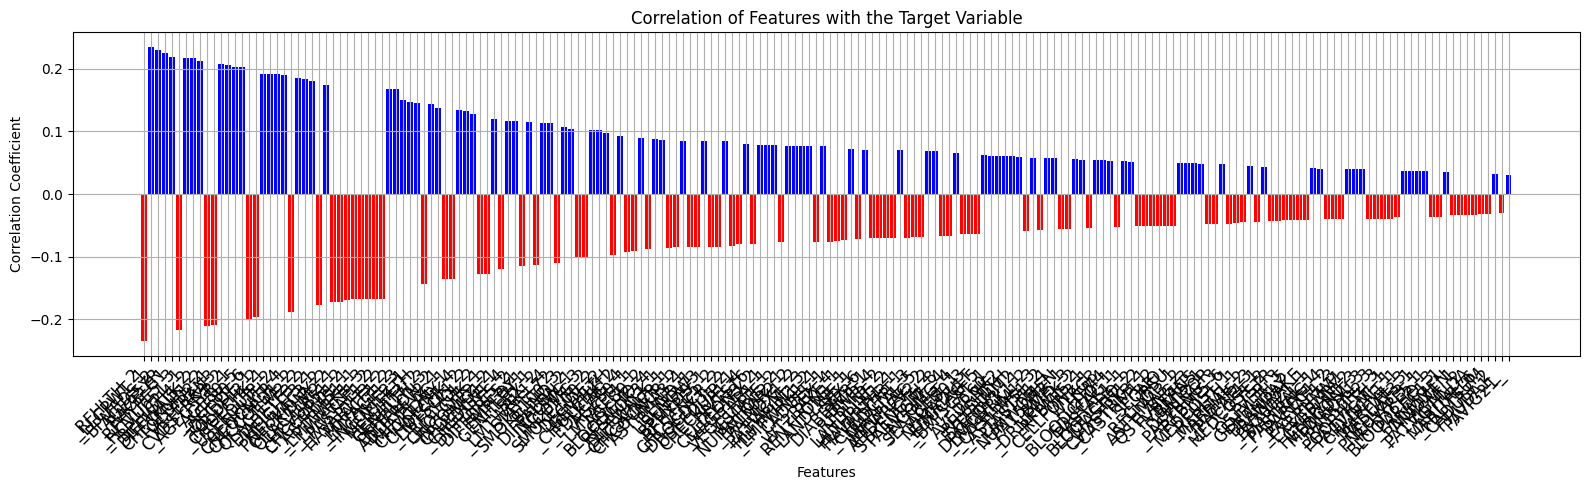

Number of features removed due to low correlation: 206
Number of features kept: 196


In [99]:

import matplotlib.pyplot as plt

# Extract the Id column from x_train_cleaned
x_train_ids = x_train_cleaned[:, 0]
# Extract the features (excluding Id column)
x_train_features = x_train_cleaned[:, 1:]
# Adjust the headers accordingly
feature_headers = x_train_header_cleaned[1:]

# Extract y values
y_ids = y_train[:, 0]
y_values = y_train[:, 1]

# Create a mapping from Id to y_value
y_dict = dict(zip(y_ids, y_values))

# Map y_values to x_train_ids to ensure alignment
aligned_y_values = np.array([y_dict[id_] for id_ in x_train_ids])

# Ensure there are no NaNs in your dataset
assert np.isnan(x_train_features).sum() == 0, "There should be no NaNs in the dataset"
assert x_train_features.shape[0] == aligned_y_values.shape[0], (
    "Number of samples in the dataset and labels should be equal but found {} and {}".format(
        x_train_features.shape[0], aligned_y_values.shape[0]
    )
)

# Compute the correlation matrix
data_with_y = np.column_stack((x_train_features, aligned_y_values))
corr_matrix = np.corrcoef(data_with_y.T)

# Extract the correlations between features and y
# The last row corresponds to y
corr_to_y = corr_matrix[-1, :-1]  # Exclude the correlation of y with itself

# Set the correlation threshold
threshold = 0.03

# Identify indices of features to keep based on the threshold
columns_to_keep = [i for i, corr_value in enumerate(corr_to_y) if abs(corr_value) >= threshold]

# Filter the features in x_train_features
x_train_filtered_features = x_train_features[:, columns_to_keep]
filtered_feature_headers = [feature_headers[i] for i in columns_to_keep]

# Also update the aligned correlations
filtered_corr = corr_to_y[columns_to_keep]



# Get the absolute values and sort the features by correlation magnitude
sorted_indices = np.argsort(np.abs(filtered_corr))[::-1]
sorted_features = [filtered_feature_headers[i] for i in sorted_indices]
sorted_corr = filtered_corr[sorted_indices]

# Plot the correlation
fig, ax = plt.subplots(figsize=(16, 5))
x_labels = []
corr_values = []

for feature, corr_value in zip(sorted_features, sorted_corr):
    ax.bar(feature, corr_value, color='b' if corr_value > 0 else 'r')
    x_labels.append(feature)
    corr_values.append(corr_value)

# Set the tick labels to the features
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("Correlation Coefficient")
ax.set_xlabel("Features")
ax.set_title("Correlation of Features with the Target Variable")
ax.grid(True)
plt.tight_layout()
plt.show()

# Extract the Id column from x_test_cleaned
x_test_ids = x_test_cleaned[:, 0]
# Extract the features (excluding Id column)
x_test_features = x_test_cleaned[:, 1:]

# Ensure that the feature headers in test data match those in training data
# (excluding the Id column)
assert x_test_header_cleaned[1:] == feature_headers, "Feature headers in test data do not match training data"

# Filter features in test data
x_test_filtered_features = x_test_features[:, columns_to_keep]

# Reconstruct x_train_cleaned and x_test_cleaned with the filtered features and Id column
x_train_cleaned = np.column_stack((x_train_ids, x_train_filtered_features))
x_test_cleaned = np.column_stack((x_test_ids, x_test_filtered_features))

# Update the headers to include 'Id' and the filtered feature names
x_train_header_cleaned = ['Id'] + filtered_feature_headers
x_test_header_cleaned = ['Id'] + filtered_feature_headers

num_features_removed = len(feature_headers) - len(filtered_feature_headers)
print(f"Number of features removed due to low correlation: {num_features_removed}")
print(f"Number of features kept: {len(filtered_feature_headers)}")


